In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import copy
import math
import scipy
from scipy.fft import fft, fftfreq, fftshift

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

print(sklearn.__version__)

1.1.2


Bennet_4_autolabeled.csv
data processed
(111133, 9)
(8801, 9)
trained
(111133,)
(8801,)


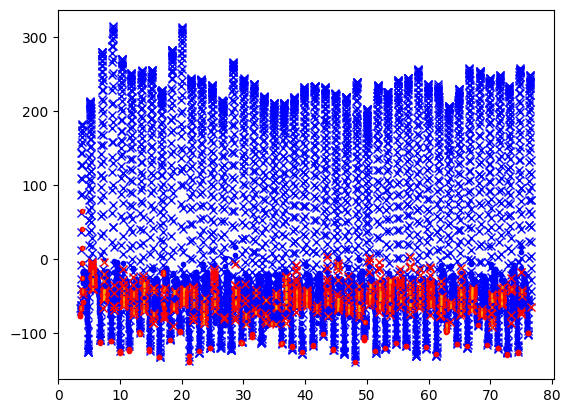

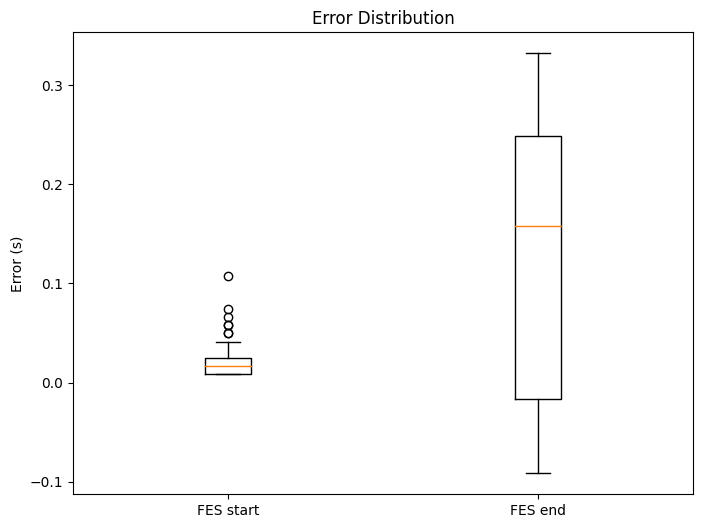

Bennet_5_autolabeled.csv
data processed
(109095, 9)
(10839, 9)
trained
(109095,)
(10839,)


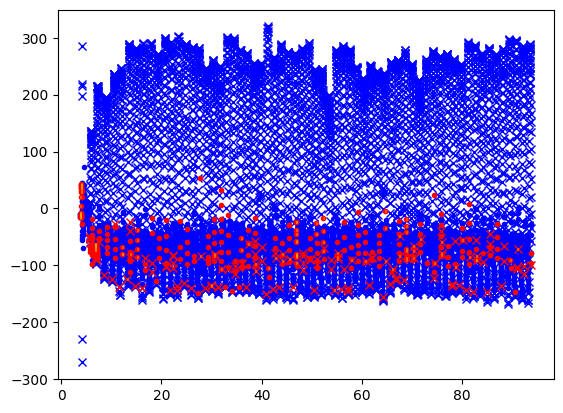

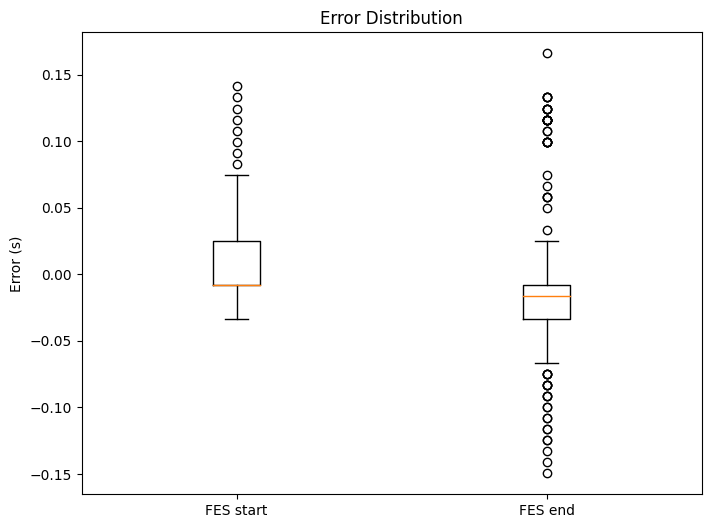

Bennet_6_autolabeled.csv
data processed
(110932, 9)
(9002, 9)
trained
(110932,)
(9002,)


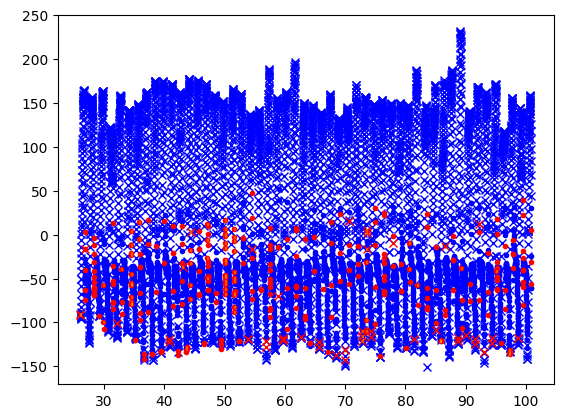

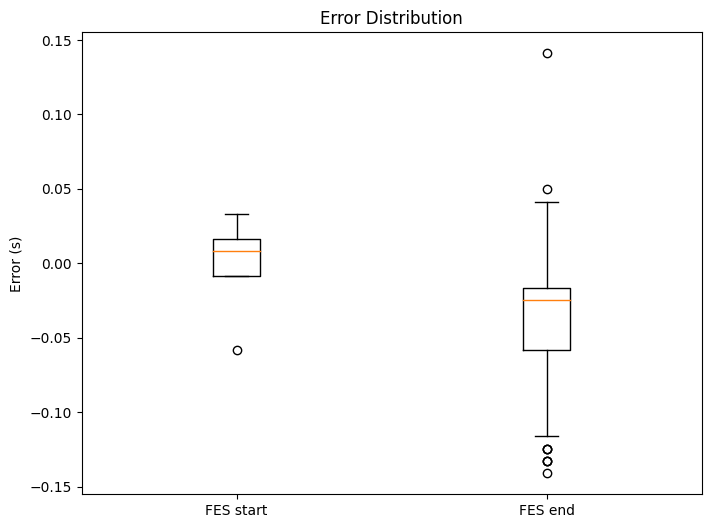

Bennet_7_autolabeled.csv
data processed
(109044, 9)
(10890, 9)
trained
(109044,)
(10890,)


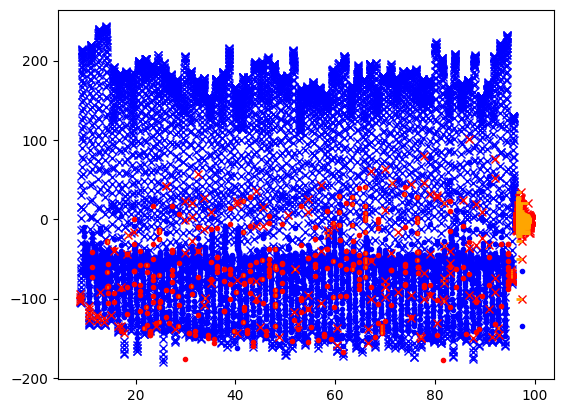

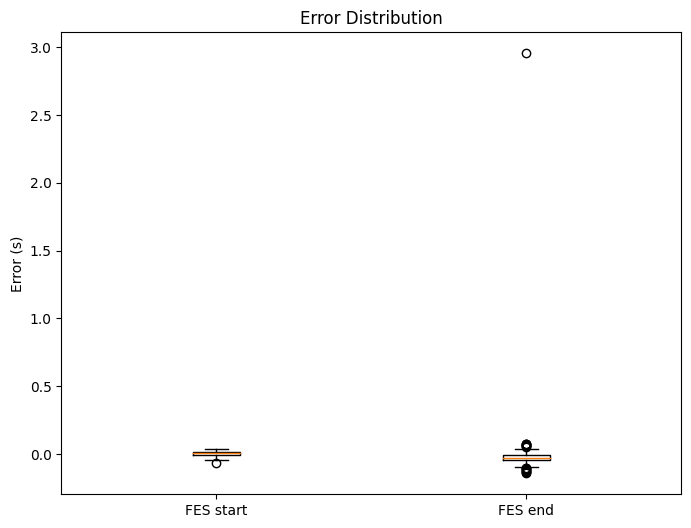

Vincent_4_autolabeled.csv
data processed
(109530, 9)
(10404, 9)
trained
(109530,)
(10404,)


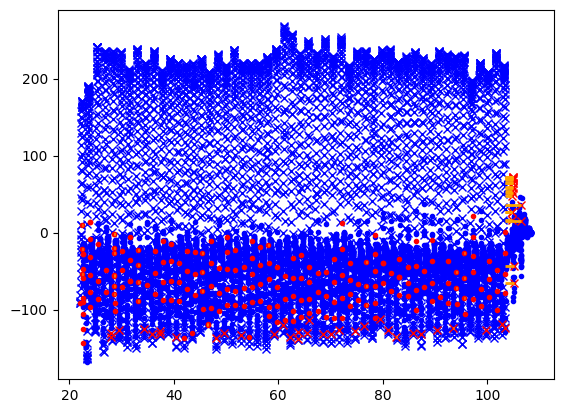

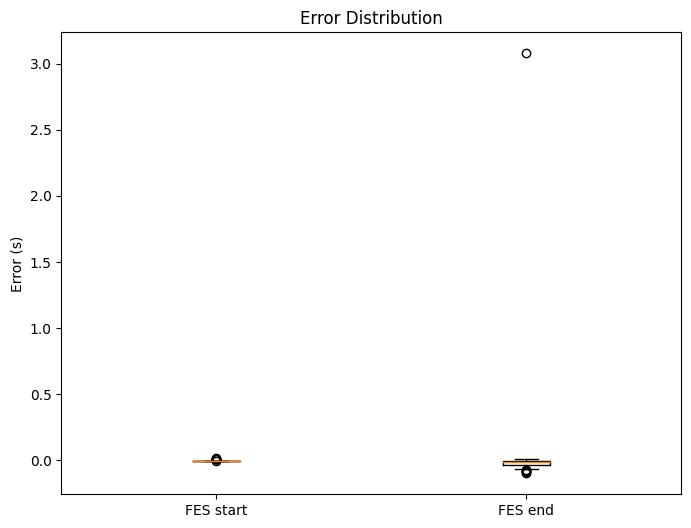

Vincent_5_autolabeled.csv
data processed
(108572, 9)
(11362, 9)
trained
(108572,)
(11362,)


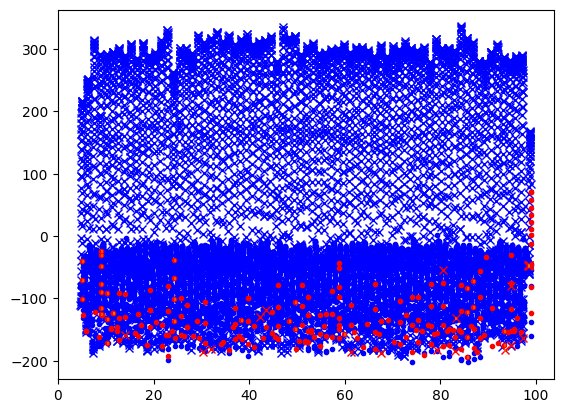

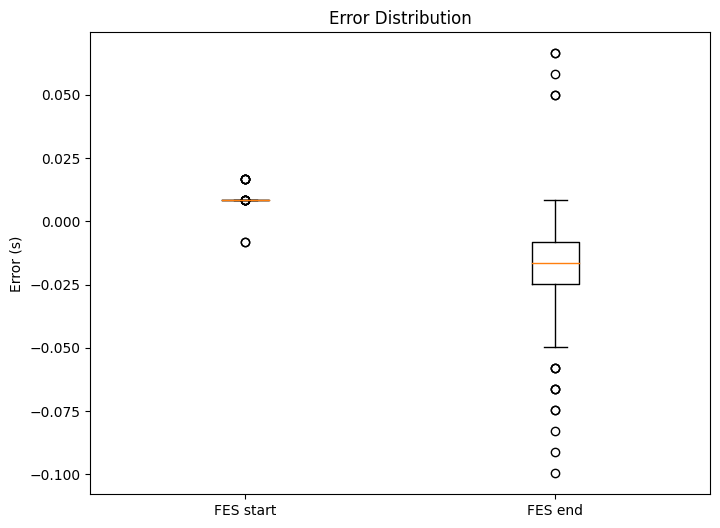

Vincent_6_autolabeled.csv
data processed
(109369, 9)
(10565, 9)
trained
(109369,)
(10565,)


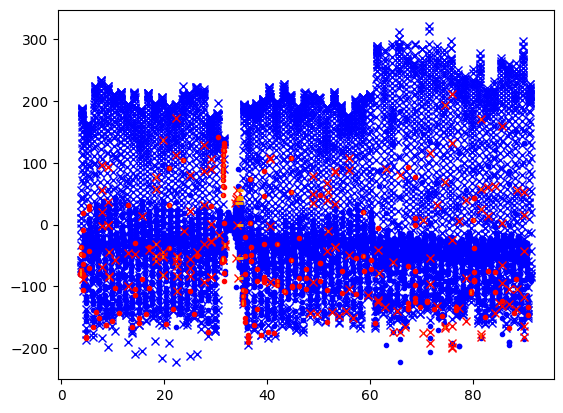

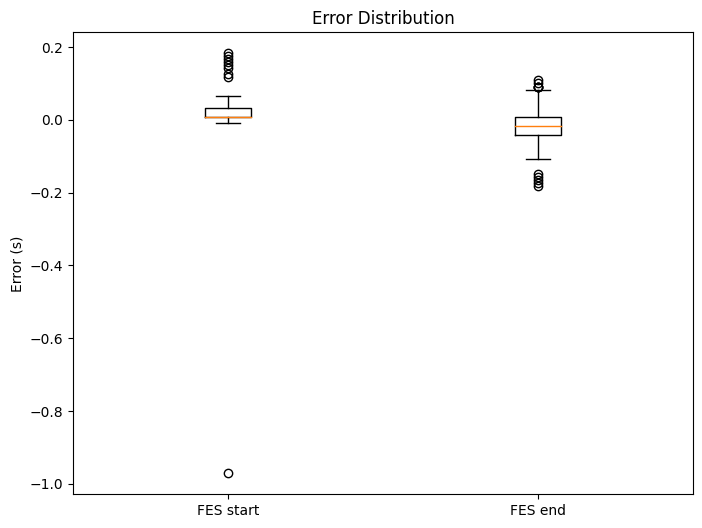

Vincent_7_autolabeled.csv
data processed
(110194, 9)
(9740, 9)
trained
(110194,)
(9740,)


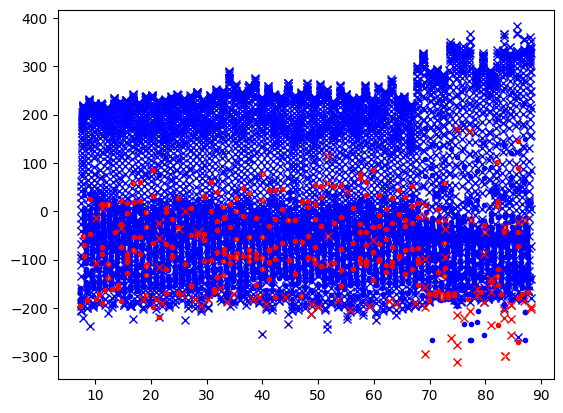

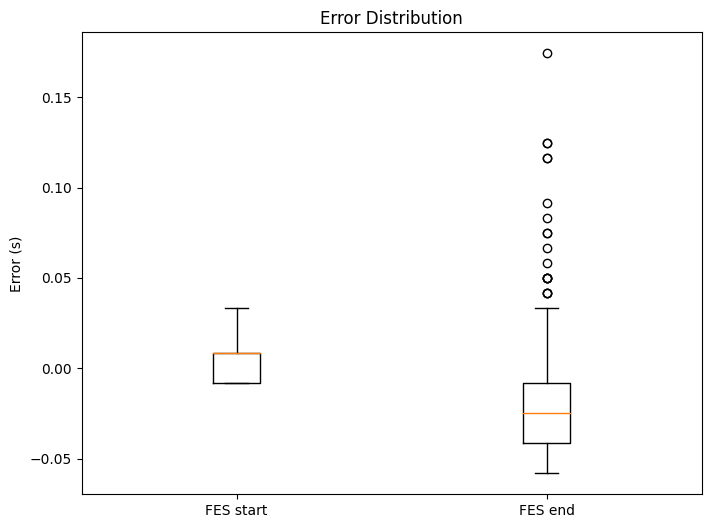

Griffin_4_autolabeled.csv
data processed
(110083, 9)
(9851, 9)
trained
(110083,)
(9851,)


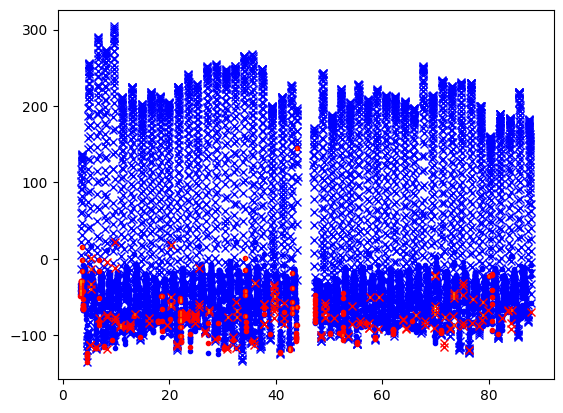

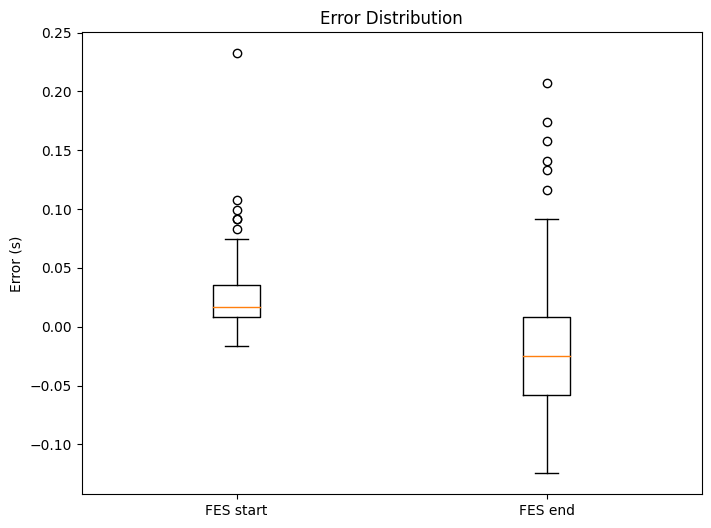

Griffin_5_autolabeled.csv
data processed
(109781, 9)
(10153, 9)
trained
(109781,)
(10153,)


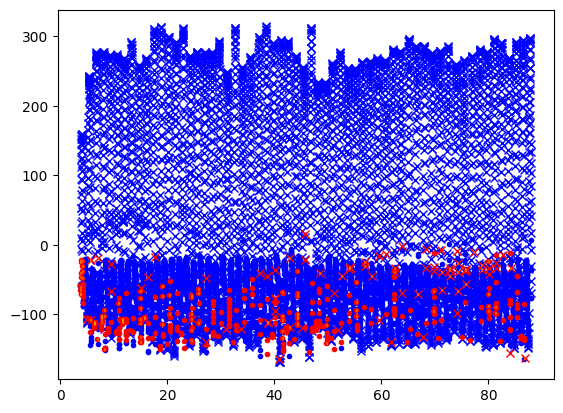

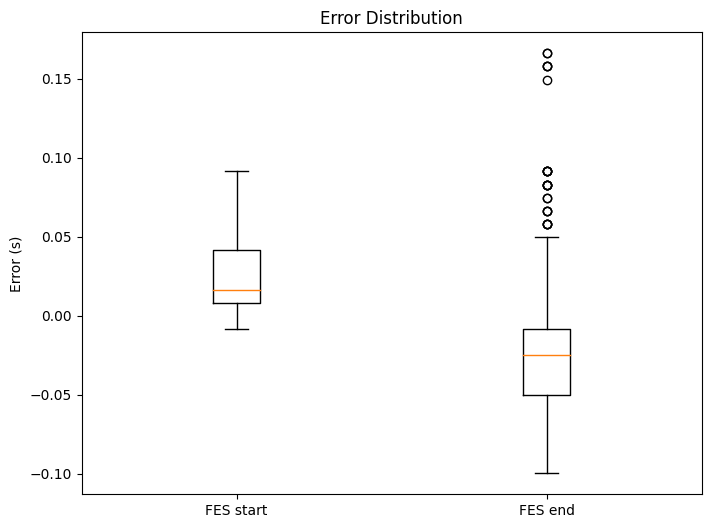

Griffin_6_autolabeled.csv
data processed
(110145, 9)
(9789, 9)
trained
(110145,)
(9789,)


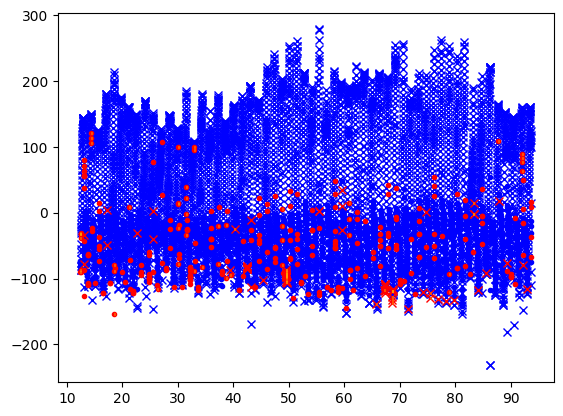

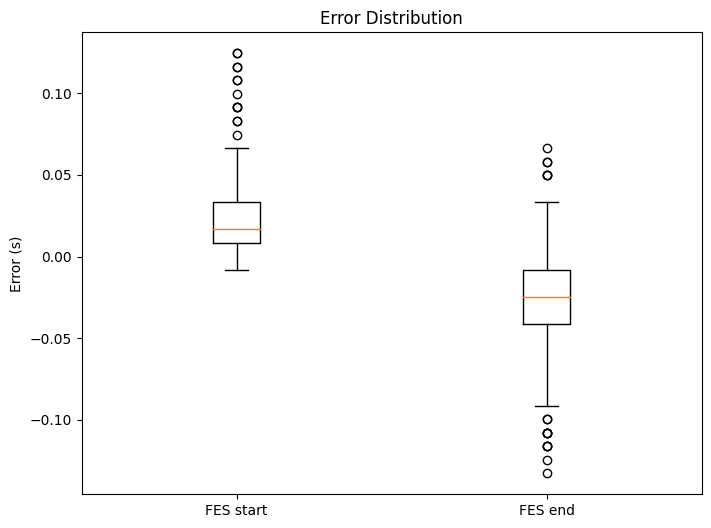

Griffin_7_autolabeled.csv
data processed
(111396, 9)
(8538, 9)
trained
(111396,)
(8538,)


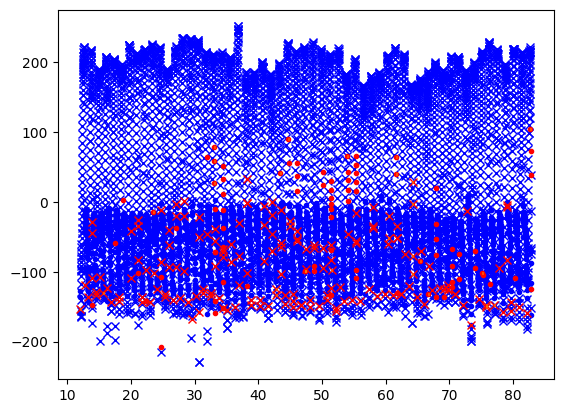

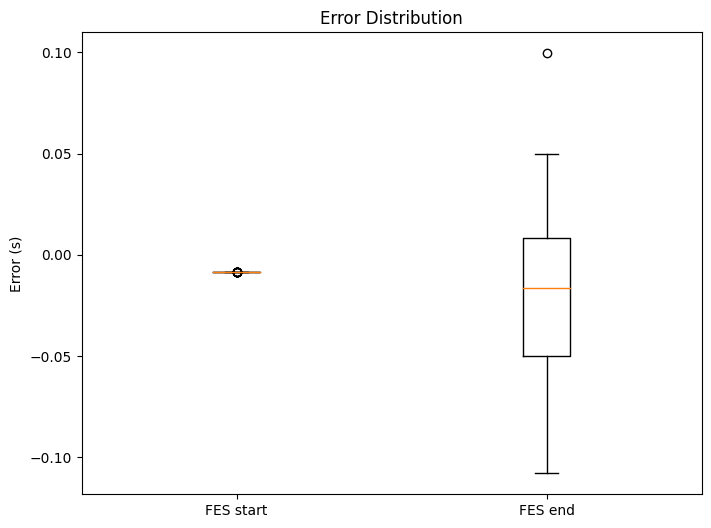

813


In [3]:
# data

# combination data
csv_files = [
             'Bennet_4_autolabeled.csv','Bennet_5_autolabeled.csv','Bennet_6_autolabeled.csv','Bennet_7_autolabeled.csv',
            
             'Vincent_4_autolabeled.csv','Vincent_5_autolabeled.csv','Vincent_6_autolabeled.csv','Vincent_7_autolabeled.csv',
         
             'Griffin_4_autolabeled.csv','Griffin_5_autolabeled.csv','Griffin_6_autolabeled.csv','Griffin_7_autolabeled.csv']

# healthy normal speeds
#csv_files = [

#            'Bennet_1_autolabeled.csv','Bennet_2_autolabeled.csv','Bennet_3_autolabeled.csv',

#           'Vincent_1_autolabeled.csv','Vincent_2_autolabeled.csv','Vincent_3_autolabeled.csv',

#           'Griffin_1_autolabeled.csv','Griffin_2_autolabeled.csv','Griffin_3_autolabeled.csv']



max_TO_errors = []
max_HS_errors = []
hist_trial_max_TO_errors = []
hist_trial_max_HS_errors = []

step_periods = []

# train on groups of readings?
memory = False

for test_index, test_file in enumerate(csv_files):
    
    print(test_file)
    
    # initialize list of errors
    trial_max_TO_errors = []
    trial_max_HS_errors = []
    
    
    # training data
    data_train = np.empty((0, 12))
    
    for i, file in enumerate(csv_files):
        if i == test_index:
            continue
        trial_to_add = np.genfromtxt(file, delimiter=',', skip_header=2)
        
        #first_spike_index = np.where(trial_to_add[:,7] > 100)[0][0]
        #last_spike_index = np.where(trial_to_add[:,7] > 100)[0][-1]
        
        #trial_to_add = trial_to_add[first_spike_index:last_spike_index,:]
        
        #b = trial_to_add[::-1]
        #first_label_index = np.argmax(b[:,11]) # find the index of the first label in the trial
        #last_label_index = len(b[:,11]) - np.argmax(b[:,11]) - 1 # find the index of the last label in the trial
        #trial_to_add = trial_to_add[(first_label_index-1):(last_label_index+1),:] # use only labeled portion of the trial
        
        # correct for left/right leg placement
        if (file=='Griffin_1_autolabeled.csv' or file=='Griffin_2_autolabeled.csv' or file=='Griffin_3_autolabeled.csv'
            or file=='Bennet_1_autolabeled.csv' or file=='Bennet_2_autolabeled.csv' or file=='Bennet_3_autolabeled.csv'
            or file=='Vincent_1_autolabeled.csv' or file=='Vincent_2_autolabeled.csv' or file=='Vincent_3_autolabeled.csv'):
            trial_to_add[:,[1,3,5,7,8,10]] = -trial_to_add[:,[1,3,5,7,8,10]].astype(float)
            
            
        #trial_to_add = np.delete(trial_to_add,[0,4], 1) # delete useless readings
            
        if memory:
            # Stagger rows and stack columns to emulate memory
            staggered_train = copy.deepcopy(trial_to_add)
            staggered_train = np.delete(staggered_train, -1, axis=0) # delete last row to create offset
            staggered_train = np.delete(staggered_train,-1, axis=1) # delete label from previous readings
            staggered_train = np.delete(staggered_train,[0,4], 1) # delete useless readings
            trial_to_add = np.delete(trial_to_add, 0, axis=0) # delete first row from trial
            trial_to_add = np.hstack((trial_to_add, staggered_train)) # stack previous readings onto current readings
            

            
        data_train = np.vstack([data_train, trial_to_add]) # stack all training files into single array

    data_train_x = np.delete(data_train, 11, 1) # delete label from features
    data_train_y = data_train[:,11]

    # testing data
    data_test = np.genfromtxt(test_file, delimiter=',', skip_header=2)
    
    #first_spike_index = np.where(data_test[:,7] > 100)[0][0]
    #last_spike_index = np.where(data_test[:,7] > 100)[0][-1]
    
    #data_test = data_test[first_spike_index:last_spike_index,:]
    
    
    #b = data_test[::-1]
    #first_label_index = np.argmax(b[:,11]) # find the index of the first label in the trial
   
    #last_label_index = len(b[:,11]) - np.argmax(b[:,11]) - 1
    
    #data_test = data_test[(first_label_index-1):(last_label_index+1),:] # use only labeled portion
    
    
    
    # correct for left/right leg placement
    if (test_file=='Griffin_1_autolabeled.csv' or test_file=='Griffin_2_autolabeled.csv' or test_file=='Griffin_3_autolabeled.csv'
            or test_file=='Bennet_1_autolabeled.csv' or test_file=='Bennet_2_autolabeled.csv' or test_file=='Bennet_3_autolabeled.csv'
            or test_file=='Vincent_1_autolabeled.csv' or test_file=='Vincent_2_autolabeled.csv' or test_file=='Vincent_3_autolabeled.csv'):
            data_test[:,[1,3,5,7,8,10]] = -data_test[:,[1,3,5,7,8,10]].astype(float)
            
    #data_test = np.delete(data_test, [0,4], 1) # delete useless readings
            
    if memory:
        # Stagger rows and stack columns to emulate memory
        staggered_test = copy.deepcopy(data_test)
        staggered_test = np.delete(staggered_test,-1,axis=0)
        staggered_test = np.delete(staggered_test,-1, axis=1) # delete label from previous readings
        staggered_test = np.delete(staggered_test, [0,4], 1)
        data_test = np.delete(data_test, 0, axis=0)
        data_test = np.hstack((data_test, staggered_test))

    
    
    data_test_x = np.delete(data_test, 11, 1) # delete label from features
    data_test_y = data_test[:,11]

    # cast features to int/float values
    data_train_x=data_train_x.astype('float')
    data_test_x=data_test_x.astype('float')

    data_train_y=data_train_y.astype('int')
    data_test_y=data_test_y.astype('int')
    
    # normalize data
    normalizer_train = Normalizer().fit(X=data_train_x)

    data_train_normalized = normalizer_train.transform(data_train_x)
    data_test_normalized = normalizer_train.transform(data_test_x)


    # standardize data
    standardizer_train = StandardScaler().fit(X=data_train_normalized)

    data_train_normalized = standardizer_train.transform(data_train_normalized)
    data_test_normalized = standardizer_train.transform(data_test_normalized)
    
    data_train_normalized = np.delete(data_train_normalized,[0,4], 1)
    data_test_normalized = np.delete(data_test_normalized, [0,4], 1)
    
    print('data processed')
    print(data_train_normalized.shape)
    print(data_test_normalized.shape)
    
    #Train and predict using SVM
    #model = svm.SVC(C=1, kernel='linear')
    model = svm.SVC(C=1)
    model.fit(data_train_normalized, data_train_y)
    
    print('trained')

    train_pred = model.predict(data_train_normalized)
    test_pred = model.predict(data_test_normalized)

    print(train_pred.shape)
    print(test_pred.shape)
    
    # identify the mistakes
    true_neg = data_test_x[test_pred + data_test_y == 0, :]
    false_neg = data_test_x[test_pred - data_test_y == -1, :]
    true_pos = data_test_x[test_pred + data_test_y == 2, :]
    false_pos = data_test_x[test_pred - data_test_y == 1, :]

    pos = data_test_x[data_test_y == 1, :]
    neg = data_test_x[data_test_y == 0, :]
    
    
    fig = plt.figure(test_index)
    ax = fig.add_subplot(111)
    plt.plot(true_neg[:,0], true_neg[:,7], '.', color='blue',label='true negative')
    plt.plot(true_pos[:,0], true_pos[:,7], 'x',color='blue',label='true positive')
    plt.plot(false_neg[:,0], false_neg[:,7], '.',color='red',label='false negative')
    plt.plot(false_pos[:,0], false_pos[:,7], 'x', color='red',label='false positive')

    prev_nearest_pos = -1
    
    
    TO_errors = []
    HS_errors = []
    
    TO_FP = 0
    TO_FN = 0
    HS_FP = 0
    HS_FN = 0

    step = 0
    

    # quantify the mistakes
    for FP in false_pos:
        nearest_pos = find_nearest(pos[:,0], FP[0])
        if(nearest_pos != prev_nearest_pos):
            step += 1
            TO_errors.append([])
            HS_errors.append([])

        temporal_error = FP[0] - pos[nearest_pos,0]
        
        ax.hlines(y=FP[7], xmin=min(FP[0],pos[nearest_pos,0]), xmax=max(FP[0],pos[nearest_pos,0]), linewidth=2, color='orange')
        
        if temporal_error<0:
            TO_errors[step-1].append(temporal_error)
            TO_FP += 1
        else:
            HS_errors[step-1].append(temporal_error)
            HS_FP += 1
        prev_nearest_pos = nearest_pos


        prev_nearest_neg = -1

    for FN in false_neg:
        nearest_neg = find_nearest(neg[:,0], FN[0])
        if(nearest_neg != prev_nearest_neg):
            step += 1
            TO_errors.append([])
            HS_errors.append([])

        temporal_error = FN[0] - neg[nearest_neg,0]
        
        ax.hlines(y=FN[7], xmin=min(FN[0],neg[nearest_neg,0]), xmax=max(FN[0],neg[nearest_neg,0]), linewidth=2, color='orange')
        
        if temporal_error>0:
            TO_errors[step-1].append(temporal_error)
            TO_FN += 1
        else:
            HS_errors[step-1].append(temporal_error)
            HS_FN += 1

        prev_nearest_neg = nearest_pos    
    
        
    # find max error per step
    for step_errors in TO_errors:
        if len(step_errors) > 0:
            max_TO_errors.append(max(step_errors))
            trial_max_TO_errors.append(max(step_errors))

    for step_errors in HS_errors:
        if len(step_errors) > 0:
            max_HS_errors.append(max(step_errors))
            trial_max_HS_errors.append(max(step_errors))
            

    
    
    plt.show()
            
    # create box plot for current trial
    fig, ax = plt.subplots(figsize=(8,6))
    ax.boxplot([trial_max_TO_errors, trial_max_HS_errors], labels=['FES start', 'FES end']) 
    # set labels and title
    ax.set_title('Error Distribution')
    ax.set_ylabel('Error (s)')

    plt.show()
    
    
    hist_trial_max_TO_errors.append(trial_max_TO_errors)
    hist_trial_max_HS_errors.append(trial_max_HS_errors)
    
    TO_errors.clear()
    HS_errors.clear()
    
    
print(len(max_TO_errors))



In [4]:
# find step period for each trial
step_periods = []

for index, file in enumerate(csv_files):
    
    # testing data
    data = np.genfromtxt(file, delimiter=',', skip_header=2)
    
    
    
    
    # correct for left/right leg placement
    if (file=='Griffin_1_autolabeled.csv' or file=='Griffin_2_autolabeled.csv' or file=='Griffin_3_autolabeled.csv'
        or file=='Bennet_1_autolabeled.csv' or file=='Bennet_2_autolabeled.csv' or file=='Bennet_3_autolabeled.csv'
        or file=='Vincent_1_autolabeled.csv' or file=='Vincent_2_autolabeled.csv' or file=='Vincent_3_autolabeled.csv'):
          trial_to_add[:,[1,3,5,7,8,10]] = -trial_to_add[:,[1,3,5,7,8,10]].astype(float)
            
    
    x = data[:,0]
    y = -data[:,7]
    N = data.shape[0]
    T = x[1] - x[0]
    xf = fftfreq(N, T)
    yf = fft(y)

    thresh = 10
    first_spike_bound = xf[(1/N*np.abs(yf)) > thresh] + 0.25  # find the frequencies with power spectral density values above the threshold


    freq = xf[np.argmax(yf[np.logical_and(xf>0,xf<first_spike_bound[0])])]
    period = 1/freq


    print('step period = ', period, 's')
    step_periods.append(period)

step period =  1.6233051388666295 s
step period =  1.384064927261567 s
step period =  1.358491819999837 s
step period =  1.3506945017909289 s
step period =  1.5719611679998968 s
step period =  1.291851462164354 s
step period =  1.4143133751612846 s
step period =  1.138626440281664 s
step period =  1.7774212838043582 s
step period =  1.5048283454286024 s
step period =  1.4254243763159233 s
step period =  1.2217877999999465 s


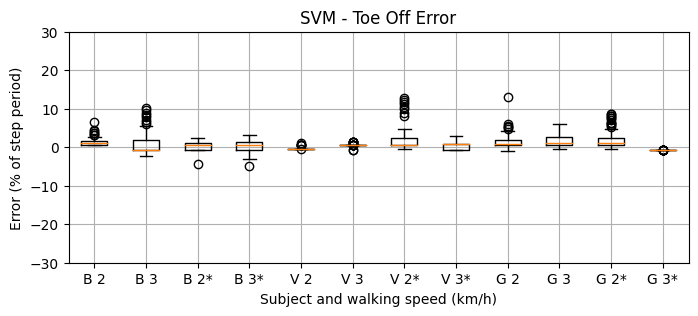

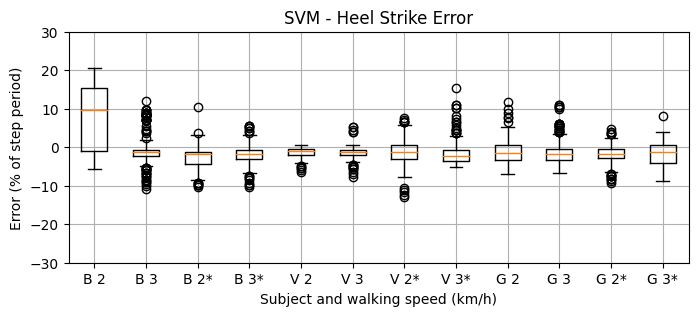

In [5]:
# plot error as a function of gait period

hist_trial_max_TO_errors_normalized = []
hist_trial_max_HS_errors_normalized = []

for i in range(len(hist_trial_max_TO_errors)): 
    trial_max_TO_errors = hist_trial_max_TO_errors[i]
    trial_max_HS_errors = hist_trial_max_HS_errors[i]
    step_period = step_periods[i]
    hist_trial_max_TO_errors_normalized.append([x/step_period*100 for x in trial_max_TO_errors])
    hist_trial_max_HS_errors_normalized.append([x/step_period*100 for x in trial_max_HS_errors])


fig, ax = plt.subplots(figsize=(8,3))

#positions = [1, 2, 3, 4, 5, 6, 7, 8 ,9]
#labels = ['B 3.5', 'B 5', 'B 6.5','V 3.5', 'V 5', 'V 6.5','G 3.5', 'G 5', 'G 6.5']
positions = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12]
labels = ['B 2', 'B 3', 'B 2*', 'B 3*', 'V 2', 'V 3', 'V 2*', 'V 3*', 'G 2', 'G 3', 'G 2*', 'G 3*']



plt.boxplot(hist_trial_max_TO_errors_normalized, positions=positions)

ax.set_title('SVM - Toe Off Error')
ax.set_xlabel('Subject and walking speed (km/h)')
ax.set_ylabel('Error (% of step period)')
ax.set_xticklabels(labels)  # add labels to x-axi  s ticks
plt.ylim(-30,30)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(8,3))


plt.boxplot(hist_trial_max_HS_errors_normalized, positions=positions)

ax.set_title('SVM - Heel Strike Error')
ax.set_xlabel('Subject and walking speed (km/h)')
ax.set_ylabel('Error (% of step period)')
ax.set_xticklabels(labels)  # add labels to x-axis ticks
plt.ylim(-30,30)
plt.grid()
#plt.legend()
plt.show()



In [6]:
import statistics

def get_stats_of_lists(lst_of_lsts):
    """
    Calculate the mean and standard deviation of all values within a list of lists.

    Args:
        lst_of_lsts (list): List of lists containing numerical values.

    Returns:
        tuple: Mean and standard deviation of all values within the list of lists.
    """
    flattened_lst = [val for sublist in lst_of_lsts for val in sublist]  # Flatten the list of lists
    mean = statistics.mean(flattened_lst)  # Calculate the mean
    stdev = statistics.stdev(flattened_lst)  # Calculate the standard deviation
    return mean, stdev

In [7]:
def flatten_list(lst_of_lsts):
    flattened_lst = [val for sublist in lst_of_lsts for val in sublist]
    return flattened_lst
    

In [11]:
flattened_TO_errors = np.array(flatten_list(hist_trial_max_TO_errors_normalized))
TO_inbounds = flattened_TO_errors[np.logical_and(flattened_TO_errors<10,flattened_TO_errors>-10)]
TO_outbounds = flattened_TO_errors[np.logical_or(flattened_TO_errors>10,flattened_TO_errors<-10)]
percent_TO_inbounds = len(TO_inbounds)/(len(TO_inbounds)+len(TO_outbounds))*100
print("percent of TO inbound = ", percent_TO_inbounds)


flattened_HS_errors = np.array(flatten_list(hist_trial_max_HS_errors_normalized))
HS_inbounds = flattened_HS_errors[np.logical_and(flattened_HS_errors<10,flattened_HS_errors>-10)]
HS_outbounds = flattened_HS_errors[np.logical_or(flattened_HS_errors>10,flattened_HS_errors<-10)]
percent_HS_inbounds = len(HS_inbounds)/(len(HS_inbounds)+len(HS_outbounds))*100
print("percent of HS outbound = ", percent_HS_inbounds)



percent of TO inbound =  99.0159901599016
percent of HS outbound =  97.8243670886076


In [9]:
# get overall stats
# compute mean and std

print("TO mean = ", get_stats_of_lists(hist_trial_max_TO_errors_normalized)[0])
print("TO std = ", get_stats_of_lists(hist_trial_max_TO_errors_normalized)[1])


print("HS mean = ", get_stats_of_lists(hist_trial_max_HS_errors_normalized)[0])
print("HS std = ", get_stats_of_lists(hist_trial_max_HS_errors_normalized)[1])



TO mean =  0.9965862878594491
TO std =  3.184087662033275
HS mean =  -1.2453251994496353
HS std =  6.844639107311529


In [10]:
# get separate stats for healthy and sim foot drop
# compute mean and std

healthy_trials = [0,1,4,5,8,9]
healthy_TO_errors = [hist_trial_max_TO_errors_normalized[i] for i in healthy_trials]
healthy_HS_errors = [hist_trial_max_HS_errors_normalized[i] for i in healthy_trials]
    
paretic_trials = [2,3,6,7,10,11]
paretic_TO_errors = [hist_trial_max_TO_errors_normalized[i] for i in paretic_trials]
paretic_HS_errors = [hist_trial_max_HS_errors_normalized[i] for i in paretic_trials]


print("healthy trials:")
print("TO mean = ", get_stats_of_lists(healthy_TO_errors)[0])
print("TO std = ", get_stats_of_lists(healthy_TO_errors)[1])


print("HS mean = ", get_stats_of_lists(healthy_HS_errors)[0])
print("HS std = ", get_stats_of_lists(healthy_HS_errors)[1])


print("paretic trials:")
print("TO mean = ", get_stats_of_lists(paretic_TO_errors)[0])
print("TO std = ", get_stats_of_lists(paretic_TO_errors)[1])


print("HS mean = ", get_stats_of_lists(paretic_HS_errors)[0])
print("HS std = ", get_stats_of_lists(paretic_HS_errors)[1])



healthy trials:
TO mean =  1.217187706699917
TO std =  1.8419273133106002
HS mean =  -0.5739429510060758
HS std =  7.064670253392515
paretic trials:
TO mean =  0.7584947309523457
TO std =  4.163752554018053
HS mean =  -1.8128147203968192
HS std =  6.602514898908911


In [14]:

print("healthy")

flattened_healthy_TO_errors = np.array(flatten_list(healthy_TO_errors))
TO_inbounds = flattened_healthy_TO_errors[np.logical_and(flattened_healthy_TO_errors<10,flattened_healthy_TO_errors>-10)]
TO_outbounds = flattened_healthy_TO_errors[np.logical_or(flattened_healthy_TO_errors>10,flattened_healthy_TO_errors<-10)]
percent_TO_inbounds = len(TO_inbounds)/(len(TO_inbounds)+len(TO_outbounds))*100
print("percent of TO inbound = ", percent_TO_inbounds)


flattened_healthy_HS_errors = np.array(flatten_list(healthy_HS_errors))
HS_inbounds = flattened_healthy_HS_errors[np.logical_and(flattened_healthy_HS_errors<10,flattened_healthy_HS_errors>-10)]
HS_outbounds = flattened_healthy_HS_errors[np.logical_or(flattened_healthy_HS_errors>10,flattened_healthy_HS_errors<-10)]
percent_HS_inbounds = len(HS_inbounds)/(len(HS_inbounds)+len(HS_outbounds))*100
print("percent of HS outbound = ", percent_HS_inbounds)


print("paretic")


flattened_paretic_TO_errors = np.array(flatten_list(paretic_TO_errors))
TO_inbounds = flattened_paretic_TO_errors[np.logical_and(flattened_paretic_TO_errors<10,flattened_paretic_TO_errors>-10)]
TO_outbounds = flattened_paretic_TO_errors[np.logical_or(flattened_paretic_TO_errors>10,flattened_paretic_TO_errors<-10)]
percent_TO_inbounds = len(TO_inbounds)/(len(TO_inbounds)+len(TO_outbounds))*100
print("percent of TO inbound = ", percent_TO_inbounds)


flattened_paretic_HS_errors = np.array(flatten_list(paretic_HS_errors))
HS_inbounds = flattened_paretic_HS_errors[np.logical_and(flattened_paretic_HS_errors<10,flattened_paretic_HS_errors>-10)]
HS_outbounds = flattened_paretic_HS_errors[np.logical_or(flattened_paretic_HS_errors>10,flattened_paretic_HS_errors<-10)]
percent_HS_inbounds = len(HS_inbounds)/(len(HS_inbounds)+len(HS_outbounds))*100
print("percent of HS outbound = ", percent_HS_inbounds)


healthy
percent of TO inbound =  99.52606635071089
percent of HS outbound =  96.45941278065631
paretic
percent of TO inbound =  98.46547314578005
percent of HS outbound =  98.97810218978103
